In [48]:
import pandas as pd
import numpy as np
from sodapy import Socrata
import requests
import requests.auth as auth
import json

In [51]:
# Get a Socrata client to pull Turnstyle data
client = Socrata("data.ny.gov", None)

# Read in name of each subway, and its lat long information
subway_to_latlong = pd.read_csv("subway.csv")

In [61]:
# A function that takes in a lat long, and using the fcc api, turns that into the census tract the station belongs to
def lat_long_to_census_tract(lat, long):
    format_str = "https://geo.fcc.gov/api/census/area?lat={}&lon={}&format=json".format(lat, long)
    response = requests.get(format_str)
    # If the lat long belongs to two census tracts, take the first one (TODO: think more about this later)
    # and return the census tract id that is formatted the way 
    # the American Community Survey expects, which is the first 11 digits of the block id. 
    return response.json()['results'][0]['block_fips'][0:11]

In [95]:
# Look at the file
subway_to_latlong.head(20)

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label
0,1,1,R01,BMT,Astoria,Astoria - Ditmars Blvd,Q,N W,Elevated,40.775036,-73.912034,NaN,Manhattan
1,2,2,R03,BMT,Astoria,Astoria Blvd,Q,N W,Elevated,40.770258,-73.917843,Ditmars Blvd,Manhattan
2,3,3,R04,BMT,Astoria,30 Av,Q,N W,Elevated,40.766779,-73.921479,Astoria - Ditmars Blvd,Manhattan
3,4,4,R05,BMT,Astoria,Broadway,Q,N W,Elevated,40.761820,-73.925508,Astoria - Ditmars Blvd,Manhattan
4,5,5,R06,BMT,Astoria,36 Av,Q,N W,Elevated,40.756804,-73.929575,Astoria - Ditmars Blvd,Manhattan
5,6,6,R08,BMT,Astoria,39 Av,Q,N W,Elevated,40.752882,-73.932755,Astoria - Ditmars Blvd,Manhattan
6,7,613,R11,BMT,Astoria,Lexington Av/59 St,M,N W R,Subway,40.762660,-73.967258,Queens,Downtown & Brooklyn
7,8,8,R13,BMT,Astoria,5 Av/59 St,M,N W R,Subway,40.764811,-73.973347,Queens,Downtown & Brooklyn
8,9,9,R14,BMT,Broadway - Brighton,57 St - 7 Av,M,N Q R W,Subway,40.764664,-73.980658,Uptown & Queens,Downtown & Brooklyn
9,10,10,R15,BMT,Broadway - Brighton,49 St,M,N R W,Subway,40.759901,-73.984139,Uptown & Queens,Downtown & Brooklyn


In [96]:
# Pull the turnstyle data, sample one working day in October to estimate commuters by station
# limit defaults to 1000, so I searched for a limit amount that comfortably got all the results
results = client.get("xfn5-qji9", date='2019-10-24T00:00:00.000', limit=35000)

In [97]:
results_df = pd.DataFrame.from_records(results)
results_df.shape[0]

29320

In [98]:
results_df.head(30)

,c_a,unit,scp,station,line_name,division,date,time,description,entries,exits
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-10-24T00:00:00.000,00:00:00,REGULAR,7244356,2454452
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-10-24T00:00:00.000,04:00:00,REGULAR,7244356,2454452
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-10-24T00:00:00.000,08:00:00,REGULAR,7244404,2454543
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-10-24T00:00:00.000,12:00:00,REGULAR,7244559,2454822
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-10-24T00:00:00.000,16:00:00,REGULAR,7244915,2454887
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-10-24T00:00:00.000,20:00:00,REGULAR,7245696,2454964
6,A002,R051,02-00-01,59 ST,NQR456W,BMT,2019-10-24T00:00:00.000,00:00:00,REGULAR,6442386,1447019
7,A002,R051,02-00-01,59 ST,NQR456W,BMT,2019-10-24T00:00:00.000,04:00:00,REGULAR,6442386,1447019
8,A002,R051,02-00-01,59 ST,NQR456W,BMT,2019-10-24T00:00:00.000,08:00:00,REGULAR,6442416,1447064
9,A002,R051,02-00-01,59 ST,NQR456W,BMT,2019-10-24T00:00:00.000,12:00:00,REGULAR,6442559,1447171


In [19]:
# The Cost of 30 day unlimited pass in 2016 and 2019
cost_30_day_unlimited_2019 = 127
cost_30_day_unlimited_2016 = 116.50
# The Federal Poverty Lines in 2016 and 2019
fpl_2016 = 11880
fpl_2019 = 12490

In [39]:
# Percent of income spend on transportation for a 30 day unlimited pass if you are at the federal poverty line in 2016
pct_of_income_transportation_2016 = cost_30_day_unlimited_2016*12*100/fpl_2016

In [40]:
# Percent of income spend on transportation for a 30 day unlimited pass if you are at the federal poverty line in 2016
pct_of_income_transportation_2019 = cost_30_day_unlimited_2019*12*100/fpl_2019

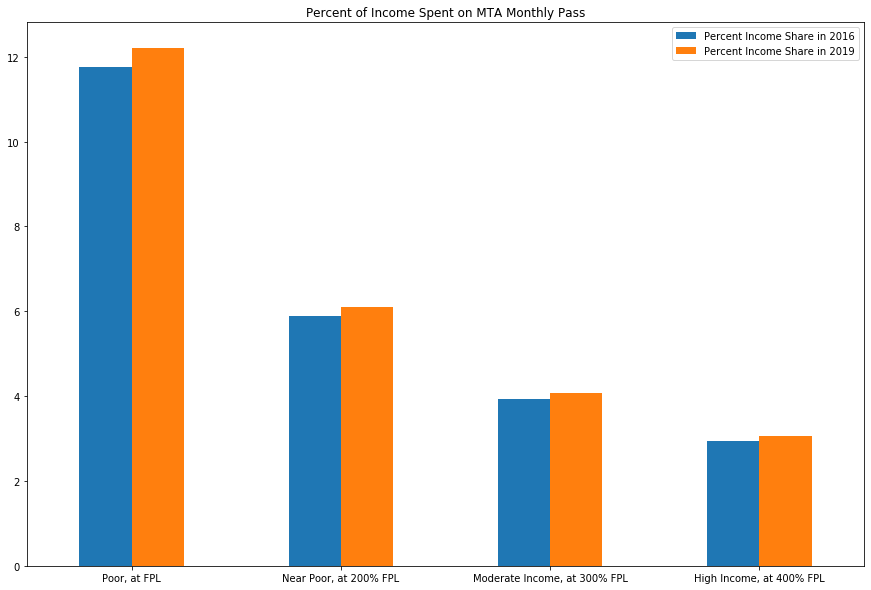

In [44]:
column_names = ['Poor, at FPL', 'Near Poor, at 200% FPL', 'Moderate Income, at 300% FPL', 'High Income, at 400% FPL']
pct_2016_FPL = [pct_of_income_transportation_2016, pct_of_income_transportation_2016/2, pct_of_income_transportation_2016/3, pct_of_income_transportation_2016/4]
pct_2019_FPL = [pct_of_income_transportation_2019, pct_of_income_transportation_2019/2, pct_of_income_transportation_2019/3, pct_of_income_transportation_2019/4]
df = pd.DataFrame({'Percent Income Share in 2016': pct_2016_FPL,
                   'Percent Income Share in 2019': pct_2019_FPL}, index=column_names)
ax = df.plot.bar(rot=0, figsize=(15,10), title="Percent of Income Spent on MTA Monthly Pass")